In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import sweetviz as sv

#from IPython.display import display
%matplotlib inline
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, plot_confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score,  RepeatedStratifiedKFold,RandomizedSearchCV, GridSearchCV

# modelos
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

In [13]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
#Remove meaningless attributes
df = df.drop(['id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [14]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [15]:
labels = [1,2,3,4,5]
df["age_mean"] = pd.cut(df["age"], 5, labels=labels)
df["age_mean"].value_counts()
#Divide the age into five groups and calculate the average BMI
grp_bmi = df.groupby("age_mean")["bmi"].mean()
grp_bmi

age_mean
1    20.787661
2    28.601332
3    31.425088
4    31.580618
5    29.415118
Name: bmi, dtype: float64

In [16]:
#The mean BMI was allocated according to age
def bmi_val(cols): 
    bmi = cols[0]
    age_mean = cols[1]
    
    if pd.isnull(bmi):
        if age_mean == 1:
            return 20.7
        elif age_mean == 2:
            return 28.6
        elif age_mean == 3:
            return 31.4
        elif age_mean == 4:
            return 31.6
        elif age_mean == 5:
            return 29.4
    else:
        return bmi
df["bmi"] = df[["bmi","age_mean"]].apply(bmi_val, axis=1)

In [17]:
#delet the age_mean attribute
df.drop("age_mean",axis=1, inplace=True)
df.isnull().sum() 

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [18]:
df.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [19]:
#There is "other" in the gender column
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [20]:
df.gender = df.gender.apply(lambda x: 0 if ((x == 'Female') or (x == 'Other')) else 1)

In [21]:
df.gender.value_counts()

0    2995
1    2115
Name: gender, dtype: int64

In [22]:
df.dtypes

gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

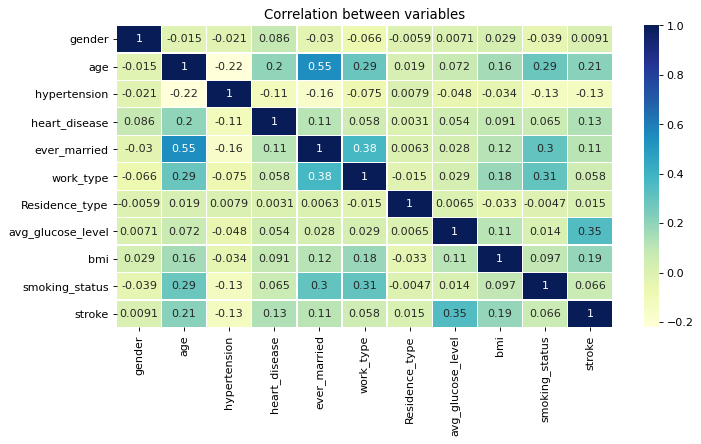

In [23]:
#Analyze the importance of attributes in the data
corrDf = df.apply(lambda x:pd.factorize(x)[0])
corrDf.head()
corr=corrDf.corr()
corr

plt.figure(figsize=(10,5),dpi=80)
ax = sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,
                linewidths=0.2,cmap="YlGnBu",annot=True)
plt.title("Correlation between variables")
plt.show()

In [24]:
#Use onehot to change object types to numbers
ohe = OneHotEncoder( sparse=False, handle_unknown = 'error')
df_t = pd.DataFrame(ohe.fit_transform(df.select_dtypes('object')))
df_t.columns = ohe.get_feature_names()
df_t.head(2)
df_t.shape

(5110, 13)

In [25]:
df_n = df.drop(df.select_dtypes('object'), axis=1)
df = pd.concat([df_t, df_n], axis=1)
df.head(2)

,x0_No,x0_Yes,x1_Govt_job,x1_Never_worked,x1_Private,x1_Self-employed,x1_children,x2_Rural,x2_Urban,x3_Unknown,x3_formerly smoked,x3_never smoked,x3_smokes,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,67.0,0,1,228.69,36.6,1
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,61.0,0,0,202.21,31.6,1


In [26]:
df.dtypes

#Divided into training and test sets
X = df.drop(columns=['stroke'])
y = df['stroke']

#SMOTE
smote=SMOTE(random_state=42) 
x_smote,y_smote=smote.fit_resample(X,y)
X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)

In [27]:
#Select the most accurate kernels of SVC
kernels = ['rbf','linear','poly','sigmoid']
model = SVC()
hyperparam = [{'kernel':kernels}]
model = GridSearchCV(SVC(),hyperparam,cv=5,verbose=1)
best_model=model.fit(X_train,y_train)
y_pred = best_model.best_estimator_.predict( X_test)

print("Best HyperParameter: ",model.best_params_)
print("Best Accuracy :",best_model.score(X_test, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best HyperParameter:  {'kernel': 'linear'}
Best Accuracy : 0.7861182519280205


In [28]:
model1 = SVC(kernel = 'linear')
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
print("Score:",model1.score(X_test, y_test))
print("Cross_val_score:", np.mean(cross_val_score(model1, X, y, cv=5)))
# Classification Report
print(classification_report(y_test, y_pred))

Score: 0.7861182519280205
Cross_val_score: 0.9512720156555773
              precision    recall  f1-score   support

           0       0.81      0.74      0.78       975
           1       0.76      0.83      0.79       970

    accuracy                           0.79      1945
   macro avg       0.79      0.79      0.79      1945
weighted avg       0.79      0.79      0.79      1945



In [29]:
# np.random.seed(42)
# clf3 = AdaBoostClassifier()
# clf3.fit(X_train, y_train)
# y_pred = clf3.predict(X_test)
# print("Score:",clf3.score(X_test, y_test))
# print("Cross_val_score ", np.mean(cross_val_score(clf3, X, y, cv=5)))
# print(classification_report(y_test, y_pred))